In [1]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from pathlib import Path

# folder containing: jet80, jet170, jet1000, lep80, lep170, lep1000
DATA_DIR = Path.home() / "ATLAS"   

SAMPLE = "jet80" 
sample_label = SAMPLE

file_path = DATA_DIR / SAMPLE

print("Opening:", file_path)
file = uproot.open(file_path)

print("File keys:", file.keys())


Opening: /Users/lydiaamstutz/ATLAS/jet80
File keys: ['CutBookkeeper_569178_450000_NOSYS;1', 'EventLoop_EventCount;1', 'EventLoop_FileExecuted;1', 'EventLoop_JobStats;1', 'EventLoop_RunTime;1', 'cflow_AnaElectrons_tight_NOSYS;1', 'cflow_AnaJets_baselineJvt_NOSYS;1', 'cflow_AnaMuons_tight_NOSYS;1', 'cflow_AnaTauJets_tight_NOSYS;1', 'listOfSystematics;1', 'metadata;1', 'reco;1']


In [3]:
# try the expected tree first
if "reco" in file:
    tree = file["reco"]
else:
    # show what trees exist so i can pick the right one
    print("Top-level keys:", file.keys())
    raise KeyError("Tree 'reco' not found. Pick the correct tree from file.keys().")

print("Tree loaded:", tree)
print("N entries:", tree.num_entries)



Tree loaded: <TTree 'reco' (136 branches) at 0x000103b8a260>
N entries: 97792


In [4]:
# find what the tau trigger branches are actually called in this ntuple
keys = tree.keys()

tau_like = [k for k in keys if ("trigPassed_HLT_tau" in k) or ("tau50" in k) or ("mediumRNN" in k)]
print("found", len(tau_like), "tau-ish branches")
for k in tau_like[:80]:
    print(k)


found 2 tau-ish branches
trigPassed_HLT_tau50_mediumRNN_tracktwoMVA_xe80_pfopufit_xe50_cell_L1XE50
trigPassed_HLT_tau50_mediumRNN_tracktwoMVA_xe80_tcpufit_xe50_cell_L1XE50


In [5]:
# find tau pt branch name in this ntuple
tau_pt_candidates = [k for k in tree.keys() if ("tau" in k.lower()) and ("pt" in k.lower())]
print("tau pt candidates:", tau_pt_candidates)


tau pt candidates: ['tau_truth_pt_invis', 'tau_truth_pt_vis', 'tau_pt_NOSYS']


In [6]:
# find jet pt branch name in this ntuple
jet_pt_candidates = [k for k in tree.keys() if ("jet" in k.lower()) and ("pt" in k.lower())]
print("jet pt candidates:", jet_pt_candidates)


jet pt candidates: ['jet_pt_NOSYS']


In [7]:
##check that the file loaded correctly

branches = [
    "eventNumber",
    "met_met_NOSYS",

    "trigPassed_HLT_xe65_cell_xe90_pfopufit_L1XE50",
    "trigPassed_HLT_xe80_cell_xe115_tcpufit_L1XE50",

    "trigPassed_HLT_j70_0eta290_020jvt_bgn160_3j70_pf_ftf_preselj50b85XX3j50_L14J20",
    "trigPassed_HLT_j75_0eta290_020jvt_bgn160_3j75_pf_ftf_preselj50b85XX3j50_L14J20",
    "tau_pt_NOSYS",
    "jet_pt_NOSYS",
    "jet_GN2v01_FixedCutBEff_85_select",
]
#add the taus
branches += [
    "trigPassed_HLT_tau50_mediumRNN_tracktwoMVA_xe80_tcpufit_xe50_cell_L1XE50",
    "trigPassed_HLT_tau50_mediumRNN_tracktwoMVA_xe80_pfopufit_xe50_cell_L1XE50",
]


arr = tree.arrays(branches, library="ak")

data = {}

for k in branches:
    if arr[k].ndim == 1:
        data[k] = np.array(arr[k])
    else:
        data[k] = arr[k].to_list()

df = pd.DataFrame(data)
offline_met_gev = df["met_met_NOSYS"].values / 1000.0



In [8]:
print("rows:", len(df))
print("unique events:", df["eventNumber"].nunique())
print("any NaNs in MET:", df["met_met_NOSYS"].isna().any())

print("MET min/max:", df["met_met_NOSYS"].min(), df["met_met_NOSYS"].max())


rows: 97792
unique events: 97792
any NaNs in MET: False
MET min/max: 0.0 941976.3


In [9]:
met_pf = (df["trigPassed_HLT_xe65_cell_xe90_pfopufit_L1XE50"] == 1)
met_hi = (df["trigPassed_HLT_xe80_cell_xe115_tcpufit_L1XE50"] == 1)

j70 = (df["trigPassed_HLT_j70_0eta290_020jvt_bgn160_3j70_pf_ftf_preselj50b85XX3j50_L14J20"] == 1)
j75 = (df["trigPassed_HLT_j75_0eta290_020jvt_bgn160_3j75_pf_ftf_preselj50b85XX3j50_L14J20"] == 1)

tau_tcp = (df["trigPassed_HLT_tau50_mediumRNN_tracktwoMVA_xe80_tcpufit_xe50_cell_L1XE50"] == 1)
tau_pf  = (df["trigPassed_HLT_tau50_mediumRNN_tracktwoMVA_xe80_pfopufit_xe50_cell_L1XE50"] == 1)



In [10]:
from itertools import combinations

base = {
    "PF_MET": met_pf,
    "TCP_MET": met_hi,
    "J70": j70,
    "J75": j75,
    "TAU+MET_PF": tau_pf,
    "TAU+MET_TCP": tau_tcp,
}

# build all or/and combos
OR = {}
AND = {}

for a, b in combinations(base.keys(), 2):
    OR[f"{a} OR {b}"] = base[a] | base[b]
    AND[f"{a} AND {b}"] = base[a] & base[b]

print(f"\nBuilt {len(OR)} OR combos and {len(AND)} AND combos.")

# Overall efficiencies: triggers
print("\n=== Overall efficiencies (Triggers) ===")
for name in base:
    print(f"{name:15s}  eff={base[name].mean():.4f}  passed={base[name].sum()}")

# Overall efficiencies: all ORs 
print("\n=== Overall efficiencies (All OR combos) ===")
for name in sorted(OR.keys()):
    print(f"{name:45s}  eff={OR[name].mean():.4f}")

# Overall efficiencies: all ANDs 
print("\n=== Overall efficiencies (All AND combos) ===")
for name in sorted(AND.keys()):
    print(f"{name:45s}  eff={AND[name].mean():.4f}")

# A few specific combos
print("\n=== Specific combos ===")
print("PF_MET OR TAU+MET_PF:", OR["PF_MET OR TAU+MET_PF"].mean())
print("J70 OR TAU+MET_PF:", OR["J70 OR TAU+MET_PF"].mean())
print("PF_MET OR J70:", OR["PF_MET OR J70"].mean())



Built 15 OR combos and 15 AND combos.

=== Overall efficiencies (Triggers) ===
PF_MET           eff=0.1464  passed=14314
TCP_MET          eff=0.0938  passed=9176
J70              eff=0.0477  passed=4667
J75              eff=0.0362  passed=3538
TAU+MET_PF       eff=0.0252  passed=2466
TAU+MET_TCP      eff=0.0271  passed=2655

=== Overall efficiencies (All OR combos) ===
J70 OR J75                                     eff=0.0477
J70 OR TAU+MET_PF                              eff=0.0686
J70 OR TAU+MET_TCP                             eff=0.0702
J75 OR TAU+MET_PF                              eff=0.0578
J75 OR TAU+MET_TCP                             eff=0.0595
PF_MET OR J70                                  eff=0.1807
PF_MET OR J75                                  eff=0.1718
PF_MET OR TAU+MET_PF                           eff=0.1530
PF_MET OR TAU+MET_TCP                          eff=0.1564
PF_MET OR TCP_MET                              eff=0.1525
TAU+MET_PF OR TAU+MET_TCP                      

In [11]:
from itertools import combinations

base = {
    "PF_MET": met_pf,
    "TCP_MET": met_hi,
    "J70": j70,
    "J75": j75,
    "TAU+MET_PF": tau_pf,
    "TAU+MET_TCP": tau_tcp,
}

print("\n=== Overlap counts (A only / B only / both / neither) ===")
for a, b in combinations(base.keys(), 2):
    A = base[a]
    B = base[b]
    a_only = (A & ~B).sum()
    b_only = (~A & B).sum()
    both   = (A & B).sum()
    neither= (~A & ~B).sum()

    # usefl fractions (avoid divide-by-zero)
    frac_a_not_b = (a_only / A.sum()) if A.sum() > 0 else np.nan
    frac_b_not_a = (b_only / B.sum()) if B.sum() > 0 else np.nan

    print(f"{a:12s} vs {b:12s} | "
          f"Aonly={a_only:7d}  Bonly={b_only:7d}  both={both:7d}  neither={neither:7d} | "
          f"frac(A not B)={frac_a_not_b:.3f}  frac(B not A)={frac_b_not_a:.3f}")



=== Overlap counts (A only / B only / both / neither) ===
PF_MET       vs TCP_MET      | Aonly=   5733  Bonly=    595  both=   8581  neither=  82883 | frac(A not B)=0.401  frac(B not A)=0.065
PF_MET       vs J70          | Aonly=  13002  Bonly=   3355  both=   1312  neither=  80123 | frac(A not B)=0.908  frac(B not A)=0.719
PF_MET       vs J75          | Aonly=  13262  Bonly=   2486  both=   1052  neither=  80992 | frac(A not B)=0.927  frac(B not A)=0.703
PF_MET       vs TAU+MET_PF   | Aonly=  12501  Bonly=    653  both=   1813  neither=  82825 | frac(A not B)=0.873  frac(B not A)=0.265
PF_MET       vs TAU+MET_TCP  | Aonly=  12636  Bonly=    977  both=   1678  neither=  82501 | frac(A not B)=0.883  frac(B not A)=0.368
TCP_MET      vs J70          | Aonly=   8187  Bonly=   3678  both=    989  neither=  84938 | frac(A not B)=0.892  frac(B not A)=0.788
TCP_MET      vs J75          | Aonly=   8370  Bonly=   2732  both=    806  neither=  85884 | frac(A not B)=0.912  frac(B not A)=0.772
TCP

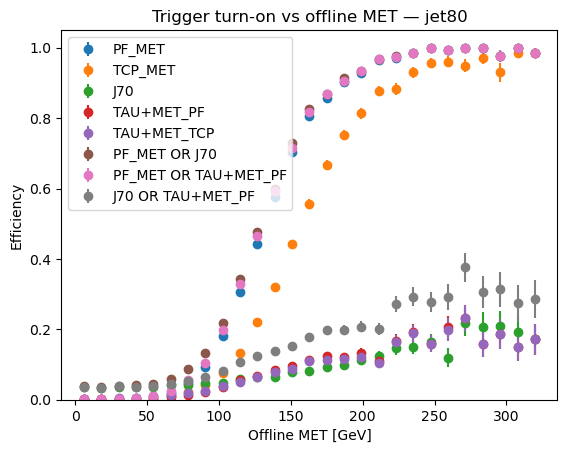


=== Per-bin quantification (100–200 GeV offline MET) ===
bin[GeV]      N    PF_MET         TAU+MET_PF     PF_MET OR TAU+MET_PF   J70 OR TAU+MET_PF
--------------------------------------------------------------------------------------------
[108.6,120.7)   4657   0.306±0.007   0.055±0.003         0.329±0.007       0.107±0.005
[120.7,132.8)   3490   0.441±0.008   0.069±0.004         0.465±0.008       0.125±0.006
[132.8,144.8)   2747   0.576±0.009   0.086±0.005         0.594±0.009       0.139±0.007
[144.8,156.9)   1989   0.704±0.010   0.095±0.007         0.716±0.010       0.153±0.008
[156.9,169.0)   1456   0.806±0.010   0.113±0.008         0.817±0.010       0.177±0.010
[169.0,181.0)   1071   0.858±0.011   0.124±0.010         0.869±0.010       0.197±0.012
[181.0,193.1)    849   0.903±0.010   0.120±0.011         0.906±0.010       0.198±0.014


In [12]:
# binomial efficiency + 1-sigma uncertainty 
def eff_err(passed, total):
    if total == 0:
        return np.nan, np.nan
    eff = passed / total
    err = np.sqrt(eff * (1 - eff) / total)
    return eff, err

bins = np.linspace(0, 350, 30)
centers = 0.5 * (bins[:-1] + bins[1:])

# choose a focused set to plot + quantify 
focus = {
    "PF_MET": base["PF_MET"],
    "TCP_MET": base["TCP_MET"],
    "J70": base["J70"],
    "TAU+MET_PF": base["TAU+MET_PF"],
    "TAU+MET_TCP": base["TAU+MET_TCP"],
    "PF_MET OR J70": OR["PF_MET OR J70"],
    "PF_MET OR TAU+MET_PF": OR["PF_MET OR TAU+MET_PF"],  
    "J70 OR TAU+MET_PF": OR["J70 OR TAU+MET_PF"],           
    "PF_MET AND TAU+MET_PF": AND["PF_MET AND TAU+MET_PF"],  
}

# storage
Nbin = []
out = {k: {"eff": [], "err": []} for k in focus.keys()}

for i in range(len(bins) - 1):
    lo, hi = bins[i], bins[i+1]
    sel = (offline_met_gev >= lo) & (offline_met_gev < hi)
    total = sel.sum()
    Nbin.append(total)

    for name, mask in focus.items():
        if total < 50:
            out[name]["eff"].append(np.nan)
            out[name]["err"].append(np.nan)
        else:
            passed = (mask & sel).sum()
            e, s = eff_err(passed, total)
            out[name]["eff"].append(e)
            out[name]["err"].append(s)

# plot with error bars 
plt.figure()
for name in ["PF_MET", "TCP_MET", "J70", "TAU+MET_PF", "TAU+MET_TCP",
             "PF_MET OR J70", "PF_MET OR TAU+MET_PF", "J70 OR TAU+MET_PF"]:
    plt.errorbar(
        centers,
        out[name]["eff"],
        yerr=out[name]["err"],
        fmt="o",
        label=name
    )

plt.xlabel("Offline MET [GeV]")
plt.ylabel("Efficiency")
plt.ylim(0, 1.05)
plt.legend()
plt.title(f"Trigger turn-on vs offline MET — {sample_label}")
plt.show()

# quantified table: 100–200 GeV 
print("\n=== Per-bin quantification (100–200 GeV offline MET) ===")
print("bin[GeV]      N    PF_MET         TAU+MET_PF     PF_MET OR TAU+MET_PF   J70 OR TAU+MET_PF")
print("-"*92)

for i in range(len(bins)-1):
    lo, hi = bins[i], bins[i+1]
    if lo < 100 or hi > 200:
        continue

    total = Nbin[i]
    if total < 50:
        continue

    def fmt(name):
        e = out[name]["eff"][i]
        s = out[name]["err"][i]
        return f"{e:6.3f}±{s:5.3f}"

    print(f"[{lo:5.1f},{hi:5.1f})  {total:5d}  "
          f"{fmt('PF_MET'):>12s}  "
          f"{fmt('TAU+MET_PF'):>12s}  "
          f"{fmt('PF_MET OR TAU+MET_PF'):>18s}  "
          f"{fmt('J70 OR TAU+MET_PF'):>16s}")


lead tau pt min/max (GeV): 25.000923828125 472.6046875


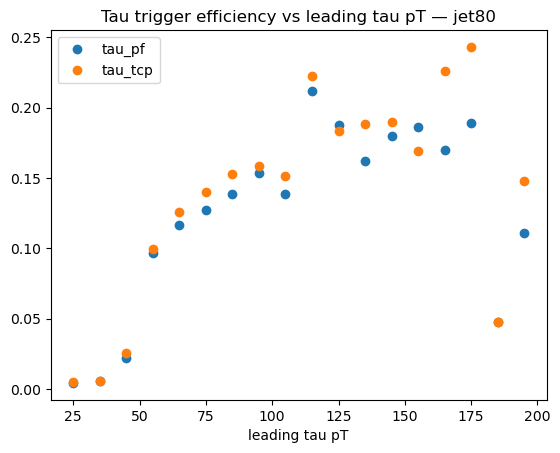

In [13]:
# tau trigger efficiency vs leading tau pt 

lead_tau_pt = []

for i in range(len(df)):
    pts = df["tau_pt_NOSYS"][i]  # list of tau pts (MeV)
    if len(pts) > 0:
        lead_tau_pt.append(max(pts) / 1000.0)  # GeV
    else:
        lead_tau_pt.append(np.nan)

lead_tau_pt = np.array(lead_tau_pt)

print("lead tau pt min/max (GeV):", np.nanmin(lead_tau_pt), np.nanmax(lead_tau_pt))

bins_tau = np.linspace(0, 300, 31)
centers = []
eff_tau_pf_pt = []
eff_tau_tcp_pt = []

for i in range(len(bins_tau) - 1):
    lo = bins_tau[i]
    hi = bins_tau[i + 1]
    sel = (lead_tau_pt >= lo) & (lead_tau_pt < hi) & np.isfinite(lead_tau_pt)

    centers.append((lo + hi) / 2)

    if sel.sum() < 20:   # smaller cutoff so don't get a billion NaNs
        eff_tau_pf_pt.append(np.nan)
        eff_tau_tcp_pt.append(np.nan)
    else:
        eff_tau_pf_pt.append(tau_pf[sel].mean())
        eff_tau_tcp_pt.append(tau_tcp[sel].mean())

plt.figure()
plt.plot(centers, eff_tau_pf_pt, "o", label="tau_pf")
plt.plot(centers, eff_tau_tcp_pt, "o", label="tau_tcp")
plt.xlabel("leading tau pT")
plt.legend()
plt.title(f"Tau trigger efficiency vs leading tau pT — {sample_label}")
plt.show()


lead b-jet pt min/max (GeV): 25.0004921875 1533.62225
fraction of events with >=1 b85 jet: 0.8605918684554974


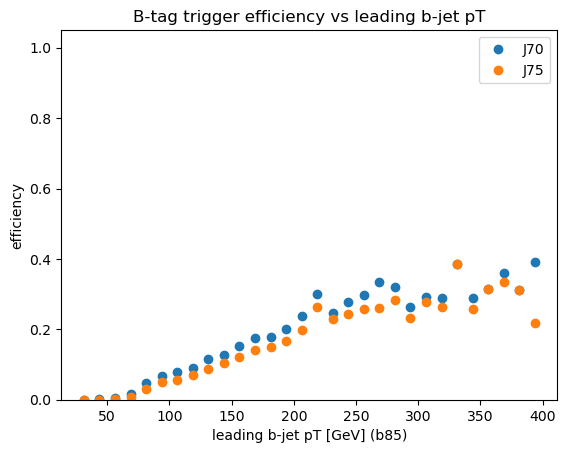

In [14]:
#  b-tag trigger efficiency vs leading b-jet pt (b85 jets) 

lead_bjet_pt = []

for i in range(len(df)):
    pts = df["jet_pt_NOSYS"][i]  # jet pts (MeV)
    b85 = df["jet_GN2v01_FixedCutBEff_85_select"][i]  # 0/1 flags

    bpts = []
    for j in range(len(pts)):
        if b85[j] == 1:
            bpts.append(pts[j])

    if len(bpts) > 0:
        lead_bjet_pt.append(max(bpts) / 1000.0)  # GeV
    else:
        lead_bjet_pt.append(np.nan)

lead_bjet_pt = np.array(lead_bjet_pt)

print("lead b-jet pt min/max (GeV):", np.nanmin(lead_bjet_pt), np.nanmax(lead_bjet_pt))
print("fraction of events with >=1 b85 jet:", np.isfinite(lead_bjet_pt).mean())

bins_b = np.linspace(0, 400, 33)
centers = []
eff_j70_bpt = []
eff_j75_bpt = []

for i in range(len(bins_b) - 1):
    lo = bins_b[i]
    hi = bins_b[i + 1]
    sel = (lead_bjet_pt >= lo) & (lead_bjet_pt < hi) & np.isfinite(lead_bjet_pt)

    centers.append((lo + hi) / 2)


    if sel.sum() < 20:   # smaller cutoff because b-jets might be rarer????
        eff_j70_bpt.append(np.nan)
        eff_j75_bpt.append(np.nan)
    else:
        eff_j70_bpt.append(j70[sel].mean())
        eff_j75_bpt.append(j75[sel].mean())

plt.figure()
plt.plot(centers, eff_j70_bpt, "o", label="J70")
plt.plot(centers, eff_j75_bpt, "o", label="J75")
plt.xlabel("leading b-jet pT [GeV] (b85)")
plt.ylabel("efficiency")
plt.ylim(0, 1.05)
plt.legend()
plt.title("B-tag trigger efficiency vs leading b-jet pT")
plt.show()


In [15]:
print("Trigger Study Summary")

# basic efficiencies
print("Basic efficiencies:")
print(" PF-MET:", round(met_pf.mean(), 3))
print(" J70:", round(j70.mean(), 3))
print(" J75:", round(j75.mean(), 3))
print(" TAU pf:", round(tau_pf.mean(), 3))
print(" TAU tcp:", round(tau_tcp.mean(), 3))
print()

# overlaps
print("Overlaps with PF-MET:")

j70_only = (j70 & ~met_pf).sum()
j75_only = (j75 & ~met_pf).sum()


if j70.sum() > 0:
    print(" frac(J70 not PF):", round(j70_only / j70.sum(), 3))

if j75.sum() > 0:
    print(" frac(J75 not PF):", round(j75_only / j75.sum(), 3))

tau_only = (tau_pf & ~met_pf).sum()
if tau_pf.sum() > 0:
    print(" frac(tau_pf not PF):", round(tau_only / tau_pf.sum(), 3))

print()

# OR gains
print("OR efficiencies:")
print(" PF only:", round(met_pf.mean(), 3))
print(" PF OR J70:", round((met_pf | j70).mean(), 3))
print(" PF OR J75:", round((met_pf | j75).mean(), 3))
print(" PF OR J70 OR J75:", round((met_pf | j70 | j75).mean(), 3))
print(" PF OR J70 OR tau:", round((met_pf | j70 | tau_pf).mean(), 3))
print(" PF OR all:", round((met_pf | met_hi | j70 | j75 | tau_pf | tau_tcp).mean(), 3))

print()




Trigger Study Summary
Basic efficiencies:
 PF-MET: 0.146
 J70: 0.048
 J75: 0.036
 TAU pf: 0.025
 TAU tcp: 0.027

Overlaps with PF-MET:
 frac(J70 not PF): 0.719
 frac(J75 not PF): 0.703
 frac(tau_pf not PF): 0.265

OR efficiencies:
 PF only: 0.146
 PF OR J70: 0.181
 PF OR J75: 0.172
 PF OR J70 OR J75: 0.181
 PF OR J70 OR tau: 0.187
 PF OR all: 0.196

